In [50]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [51]:
# colab
!unrar x ../Food_Classification_dataset -d ../

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Extracting  ../data/Sandwich/Sandwich-Train (1452).jpeg                   95%  OK 
Extracting  ../data/Sandwich/Sandwich-Train (1453).jpeg                   95%  OK 
Extracting  ../data/Sandwich/Sandwich-Train (1454).jpeg                   95%  OK 
Extracting  ../data/Sandwich/Sandwich-Train (1455).jpeg                   95%  OK 
Extracting  ../data/Sandwich/Sandwich-Train (1456).jpeg                   95%  OK 
Extracting  ../data/Sandwich/Sandwich-Train (1457).jpeg                   95%  OK 
Extracting  ../data/Sandwich/Sandwich-Train (1458).jpeg                   95%  OK 
Extracting  ../data/Sandwich/Sandwich-Train (1459).jpeg                   95%  OK 
Extracting  ../data/Sandwich/Sandwich-Train (146).jpeg                    95%  OK 
Extracting  ../data/Sandwich/Sandwich-Train (1460).jpeg                   95%  OK 
Extracting  ../

In [ ]:
# For local 

#import patoolib
#patoolib.extract_archive("Food_Classification_dataset.rar", outdir="./") 
#!pip install patool

In [52]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [53]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("Using GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using GPU


# Loading and preparing data

In [54]:
# Ścieżka do folderu z danymi
path = '/data'


In [55]:
FileNames = []
labels = []
import os
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        name = os.path.join(dirname, filename)
        FileNames.append(name)
        label = os.path.basename(os.path.dirname(os.path.join(dirname, filename)))
        labels.append(label)

In [56]:
import pandas as pd
data = pd.DataFrame()
data = data.assign(filename = FileNames, labels = labels)
data

filename         labels
0        /data/chole_bhature/403.jpg  chole_bhature
1        /data/chole_bhature/282.jpg  chole_bhature
2        /data/chole_bhature/036.jpg  chole_bhature
3        /data/chole_bhature/236.jpg  chole_bhature
4        /data/chole_bhature/159.jpg  chole_bhature
...                              ...            ...
23868  /data/jalebi/download (1).jpg         jalebi
23869           /data/jalebi/099.jpg         jalebi
23870           /data/jalebi/138.jpg         jalebi
23871           /data/jalebi/220.jpg         jalebi
23872           /data/jalebi/267.jpg         jalebi

[23873 rows x 2 columns]

##  We select several classes for the model



* There are 34 classes of dishes in the dataset.
* We select 6 of them to build the model.



In [57]:
# Wybieramy nasze klasy, które zostawimy
selected_classes = ['Baked Potato', 'Crispy Chicken', 'Fries', 'Sandwich', 'Apple Pie', 'Omelette']

data = data[data['labels'].isin(selected_classes)]
data.reset_index(inplace=True, drop=True)
data.tail()

filename     labels
7995  /data/Apple Pie/3373840.jpg  Apple Pie
7996  /data/Apple Pie/1931301.jpg  Apple Pie
7997  /data/Apple Pie/2380340.jpg  Apple Pie
7998  /data/Apple Pie/2566460.jpg  Apple Pie
7999   /data/Apple Pie/767102.jpg  Apple Pie

Frequency of data occurrence

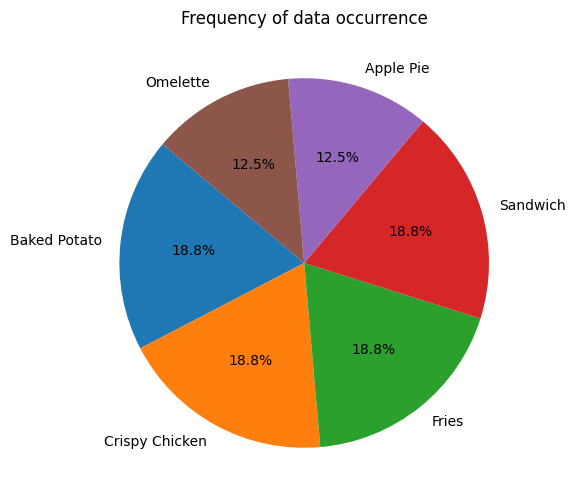

In [58]:
import matplotlib.pyplot as plt

frequency = data['labels'].value_counts()
#print(frequency)

plt.figure(figsize=(6, 6))
plt.pie(frequency.to_list(), labels=selected_classes, autopct='%1.1f%%', startangle=140)
plt.title('Frequency of data occurrence')
plt.show()


## We assign numerical labels to the selected dishes and modify the path.

In [59]:
data['labels'] = data['labels'].replace(selected_classes,
                                       [i for i in range(len(selected_classes))])

<ipython-input-59-a0d1b344926d>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['labels'] = data['labels'].replace(selected_classes,
<ipython-input-59-a0d1b344926d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['labels'] = data['labels'].replace(selected_classes,


In [60]:
def modify_path(path):
    # Removing the initial .\ if it exists
    if path.startswith('.\\'):
        path = path[2:]
    return path

# Transforming the list of paths
modified_paths = [modify_path(path) for path in data['filename']]
data['filename'] = modified_paths
data

<ipython-input-60-6d74f89b9c56>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['filename'] = modified_paths


filename  labels
0      /data/Omelette/1792393.jpg       5
1      /data/Omelette/1825409.jpg       5
2      /data/Omelette/3641223.jpg       5
3      /data/Omelette/2863566.jpg       5
4      /data/Omelette/2786843.jpg       5
...                           ...     ...
7995  /data/Apple Pie/3373840.jpg       4
7996  /data/Apple Pie/1931301.jpg       4
7997  /data/Apple Pie/2380340.jpg       4
7998  /data/Apple Pie/2566460.jpg       4
7999   /data/Apple Pie/767102.jpg       4

[8000 rows x 2 columns]

## Example images from individual classes

In [61]:
for i, item in enumerate(selected_classes, start = 1):
    print(i, item)

1 Baked Potato
2 Crispy Chicken
3 Fries
4 Sandwich
5 Apple Pie
6 Omelette


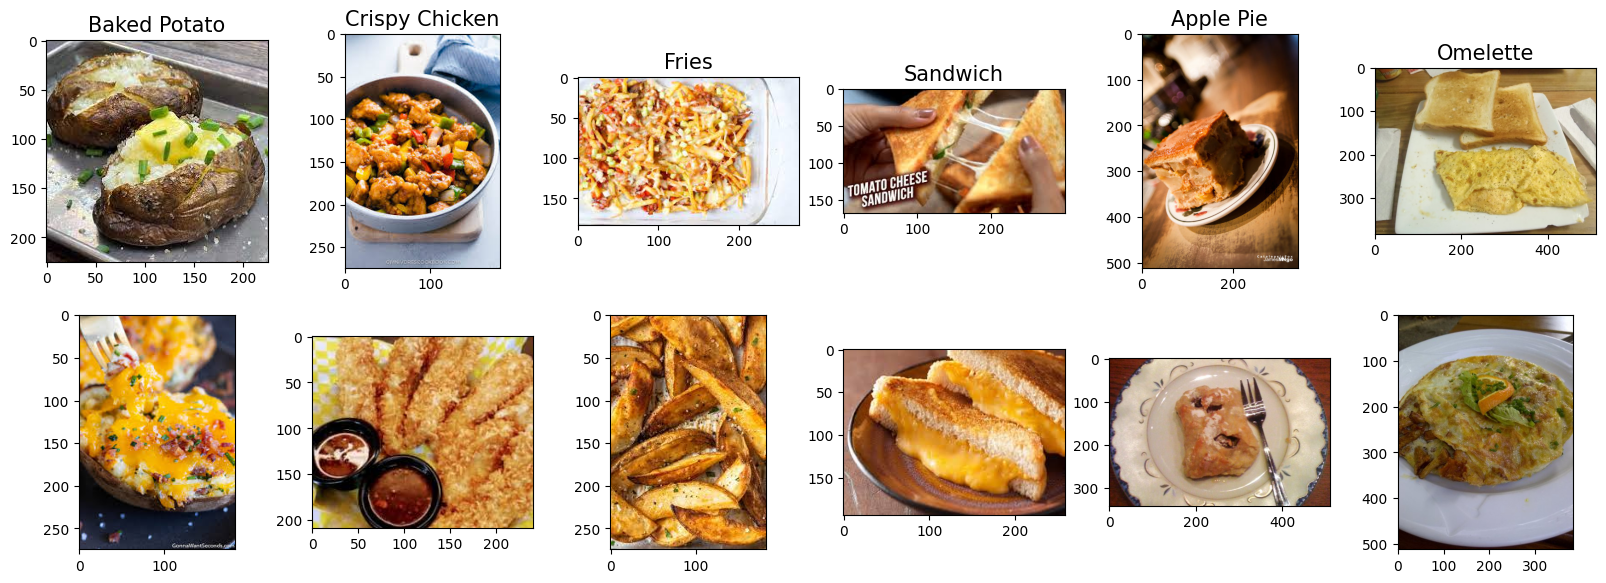

In [62]:
from torchvision import transforms
from PIL import Image

fig = plt.figure(figsize=(20, 14))

for i, item in enumerate(selected_classes, start = 1):
    ax = fig.add_subplot(4, 6, i)
    selected_path = data.loc[data['labels'] == i-1, 'filename'].iloc[i]
    img = Image.open(selected_path)
    ax.set_title(selected_classes[i-1], size=15)
    ax.imshow(img)
    ax = fig.add_subplot(4, 6, i+6)
    selected_path = data.loc[data['labels'] == i-1, 'filename'].iloc[i+1]
    img = Image.open(selected_path)
    ax.imshow(img)

plt.show()

## Split into training, validation, and test sets in a 70%, 20%, 10% ratio

In [63]:
from sklearn.model_selection import train_test_split

trainn,valid= train_test_split(data, test_size=0.3, random_state=42,shuffle=True, stratify=data['labels'])
valid,test= train_test_split(valid, test_size=1.0/3.0, random_state=42,shuffle=True, stratify=valid['labels'])

## Data transformations (examples used in our models)

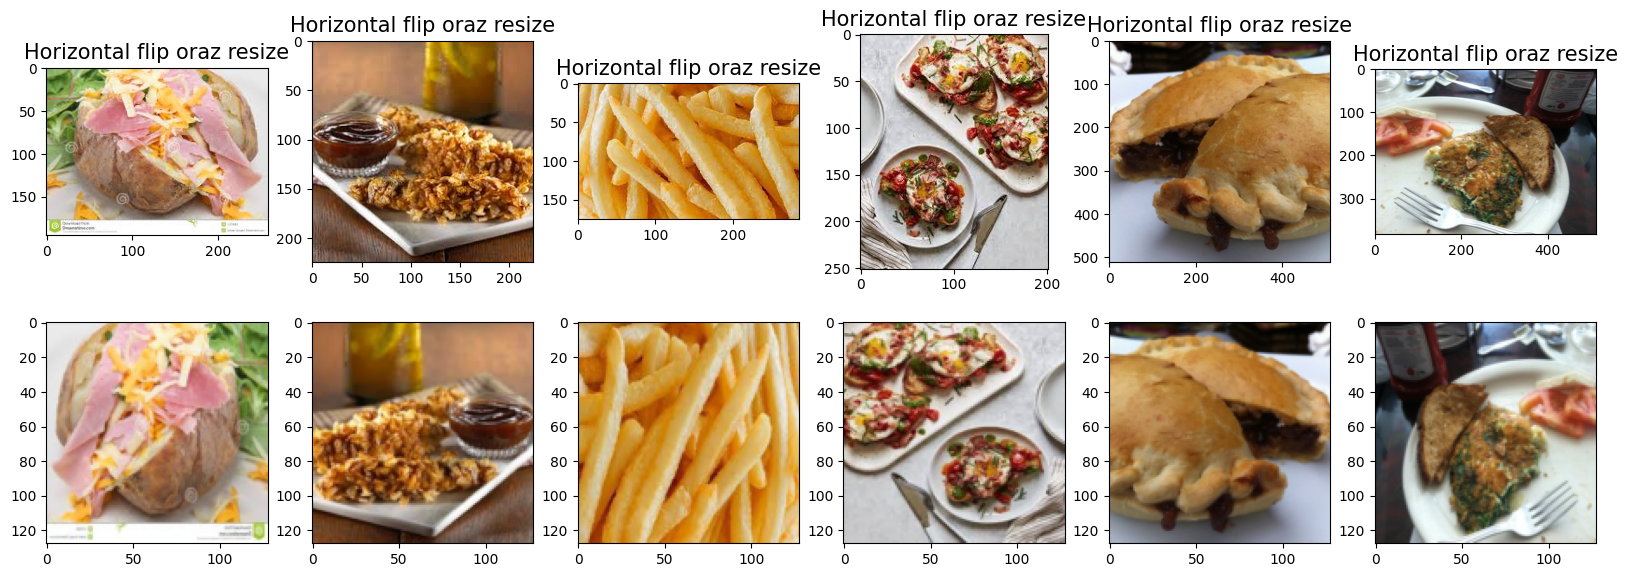

In [64]:
from torchvision import transforms
from PIL import Image

fig = plt.figure(figsize=(20, 14))

for i, item in enumerate(selected_classes, start = 1):
    ax = fig.add_subplot(4, 6, i)
    selected_path = data.loc[data['labels'] == i-1, 'filename'].iloc[i+3]
    img = Image.open(selected_path)
    ax.set_title('Horizontal flip oraz resize', size=15)
    ax.imshow(img)
    ax = fig.add_subplot(4, 6, i+6)
    img_functional_flip = transforms.functional.hflip(img)
    img_resized = transforms.functional.resize(img_functional_flip, size=(128, 128))
    ax.imshow(img_resized)

plt.show()

## Creating the ImageDataset class

In [65]:
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform
    def __getitem__(self, index):
        img = Image.open(self.file_list[index])
        if self.transform is not None:
            img = self.transform(img)
        label = self.labels[index]
        return img, label
    def __len__(self):
        return len(self.labels)

## Data augmentation techniques applied

In [66]:
from torchvision import transforms

## dla treningowego
width, hight = 64, 64
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize([width, hight]),
    transforms.ToTensor(),
])

## dla testowego oraz walidacyjnego
transform = transforms.Compose([
    transforms.Resize([width, hight]),
    transforms.ToTensor(),
])

## Using the ImageDataset class and DataLoader

In [67]:
image_train_dataset = ImageDataset(trainn['filename'].to_list(), trainn['labels'].to_list(), transform_train)
image_valid_dataset = ImageDataset(valid['filename'].to_list(), valid['labels'].to_list(), transform)
image_test_dataset = ImageDataset(test['filename'].to_list(), test['labels'].to_list(), transform)

torch.manual_seed(1)
batch_size = 32
train_dl = DataLoader(image_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(image_valid_dataset, batch_size, shuffle=False)
test_dl = DataLoader(image_test_dataset, batch_size, shuffle=False)

# Building the CNN Model

## Convolutional Layers

In [68]:
model = nn.Sequential()

#1
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())
#2
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
#3
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
#4
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

In [69]:
x = torch.ones((4, 3, width, hight))
model(x).shape

torch.Size([4, 64, 16, 16])

In [70]:
model.add_module('flatten', nn.Flatten())

x = torch.ones((4, 3, width, hight))
linear_in = model(x).shape[1]
model(x).shape

torch.Size([4, 16384])

## Fully Connected (Linear) Layers

In [71]:
model.add_module('fc1', nn.Linear(linear_in, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc3', nn.Linear(1024, len(selected_classes)))

In [72]:
model(x).shape

torch.Size([4, 6])

## Moving to GPU (if available)

In [73]:
model = model.to(device)

In [74]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Defining functions for training and testing

In [75]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [76]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            total_loss += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            total_acc += is_correct.sum().cpu()
    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

## Defining functions for visualizing results

In [77]:
def make_picture(hist):
    x_arr = np.arange(len(hist[0])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist[0], '-o', label='Train loss')
    ax.plot(x_arr, hist[1], '--<', label='Validation loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.legend(fontsize=15)
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist[2], '-o', label='Train acc.')
    ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def make_confusion_matrix(test_dl):
  y_test =test['labels'].to_list()
  pred2 = []

  with torch.no_grad():
    for x_batch, y_batch in test_dl:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      pred = model(x_batch)
      a = torch.argmax(pred, dim=1)
      a = a.tolist()
      pred2 += a

  confusion_matrix_ = confusion_matrix(y_test, pred2)
  cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_, display_labels=selected_classes)
  cm_display.plot()
  plt.xticks(rotation=40)
  plt.show()

# Training and evaluating the model

## Training the model

In [79]:
num_epochs = 20

hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.1730 val_accuracy: 0.1875
Epoch 2 accuracy: 0.1741 val_accuracy: 0.1875
Epoch 3 accuracy: 0.1941 val_accuracy: 0.2100
Epoch 4 accuracy: 0.2241 val_accuracy: 0.2463
Epoch 5 accuracy: 0.2621 val_accuracy: 0.3056
Epoch 6 accuracy: 0.3600 val_accuracy: 0.3744
Epoch 7 accuracy: 0.4484 val_accuracy: 0.4650
Epoch 8 accuracy: 0.4955 val_accuracy: 0.4994
Epoch 9 accuracy: 0.5532 val_accuracy: 0.5044
Epoch 10 accuracy: 0.6016 val_accuracy: 0.5131
Epoch 11 accuracy: 0.6430 val_accuracy: 0.5138
Epoch 12 accuracy: 0.6839 val_accuracy: 0.5394
Epoch 13 accuracy: 0.7477 val_accuracy: 0.5381
Epoch 14 accuracy: 0.7827 val_accuracy: 0.5425
Epoch 15 accuracy: 0.8227 val_accuracy: 0.5544
Epoch 16 accuracy: 0.8500 val_accuracy: 0.5469
Epoch 17 accuracy: 0.8830 val_accuracy: 0.5506
Epoch 18 accuracy: 0.9134 val_accuracy: 0.5556
Epoch 19 accuracy: 0.9136 val_accuracy: 0.5669
Epoch 20 accuracy: 0.9398 val_accuracy: 0.5594


## Plotting the graph

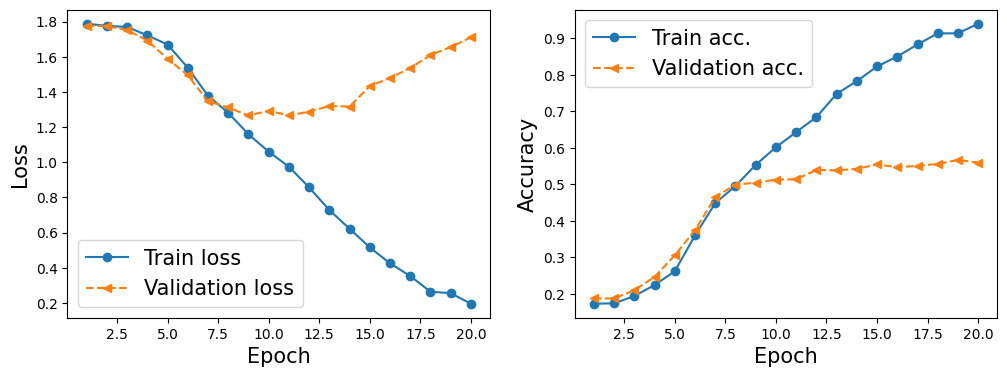

In [80]:
make_picture(hist)

# Model accuracy on the test set

In [81]:
acc_test, _ = evaluate(test_dl)
print(f'Test accuracy: {acc_test:.4f}')

Test accuracy: 0.5738


# Confusion matrix on the test set

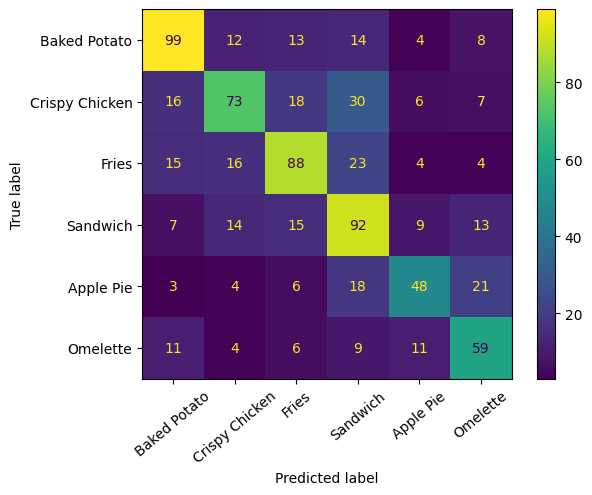

In [82]:
make_confusion_matrix(test_dl)

## A few examples of misclassified images

In [83]:
def make_pred_test_labels(test_dl):
  y_test =test['labels'].to_list()
  pred2 = []

  with torch.no_grad():
    for x_batch, y_batch in test_dl:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      pred = model(x_batch)
      a = torch.argmax(pred, dim=1)
      a = a.tolist()
      pred2 += a

  return pred2, y_test

In [84]:
pred_lab, test_lab = make_pred_test_labels(test_dl)
test.reset_index(inplace=True, drop=True)

* Upper text in black: actual label
* Lower text in red: prediction

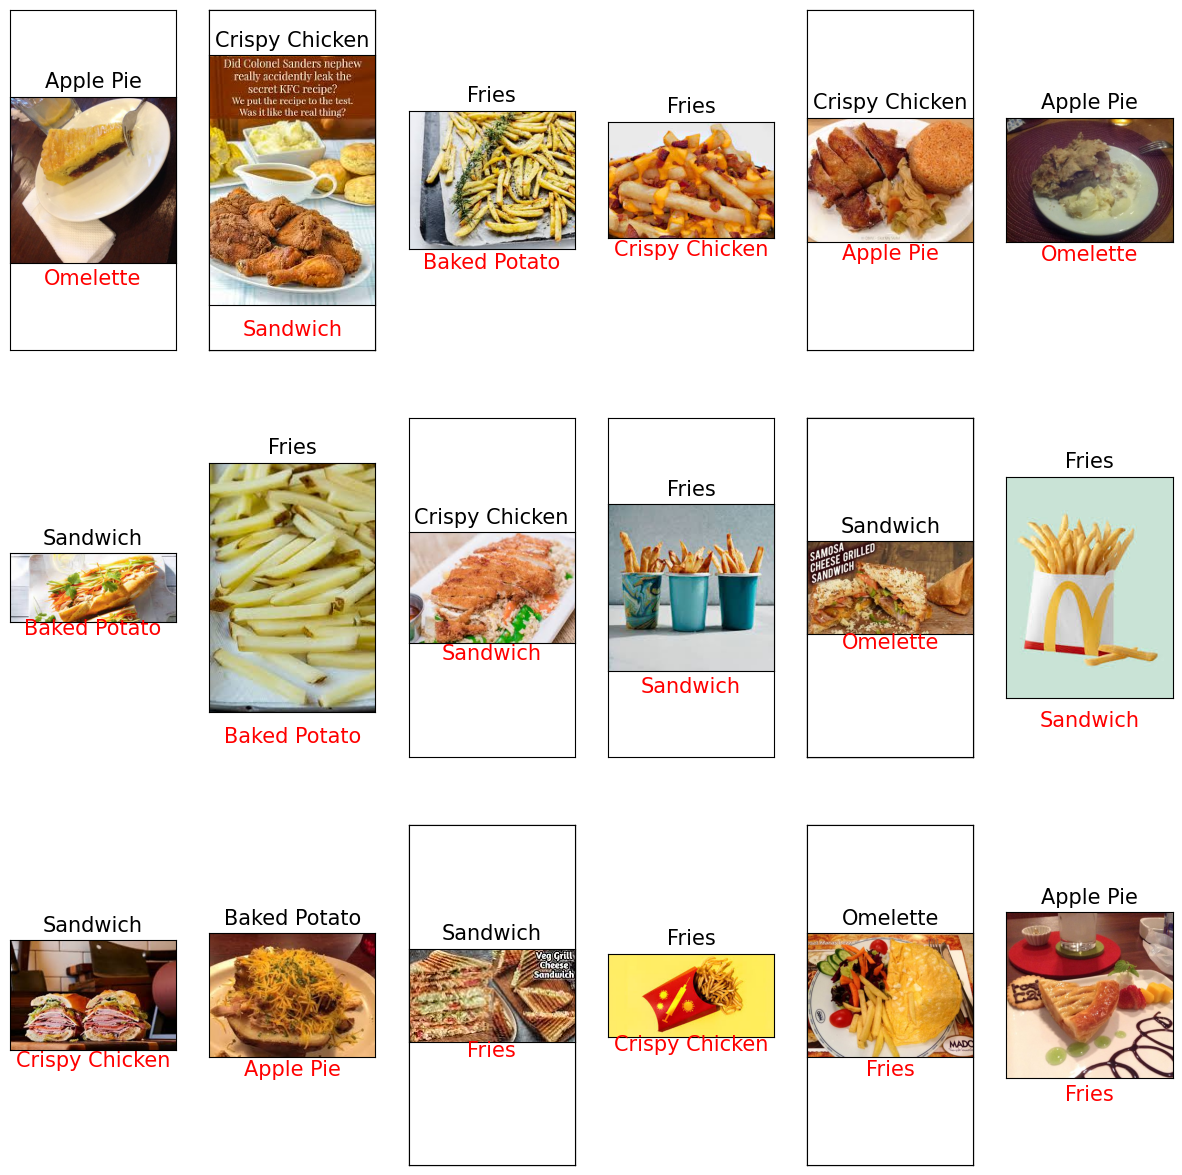

In [85]:
fig = plt.figure(figsize=(15, 15))
j=0

for i in range(len(pred_lab)):
    ax = fig.add_subplot(3, 6, j+1)
    ax.set_xticks([]); ax.set_yticks([])
    if pred_lab[i]!=test_lab[i]:
        img = Image.open(test['filename'][i])
        ax.set_title(selected_classes[test_lab[i]], size=15)
        ax.imshow(img)
        ax.text(0.5, -0.1, selected_classes[pred_lab[i]],
            size=15, color='red',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)
        j+=1
    if j>17:
        break
plt.show()

# Fine-tuning the model

## Changing resize to 128 and adding a third convolutional layer

### Augmentation (resize = 128x128)

In [86]:
from torchvision import transforms

## dla treningowego
width, hight = 128, 128
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize([width, hight]),
    transforms.ToTensor(),
])

## dla testowego oraz walidacyjnego
transform = transforms.Compose([
    transforms.Resize([width, hight]),
    transforms.ToTensor(),
])

### Preparing the dataloaders

In [87]:
image_train_dataset = ImageDataset(trainn['filename'].to_list(), trainn['labels'].to_list(), transform_train)
image_valid_dataset = ImageDataset(valid['filename'].to_list(), valid['labels'].to_list(), transform)
image_test_dataset = ImageDataset(test['filename'].to_list(), test['labels'].to_list(), transform)

torch.manual_seed(1)
batch_size = 32
train_dl = DataLoader(image_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(image_valid_dataset, batch_size, shuffle=False)
test_dl = DataLoader(image_test_dataset, batch_size, shuffle=False)

In [88]:
len(image_train_dataset)

5600

### CNN Model (additional convolutional layer)

In [89]:
model = nn.Sequential()

#1
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())
#2
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
#3
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
#4
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
#5
model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2))
model.add_module('relu3', nn.ReLU())
#6
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))

In [90]:
x = torch.ones((4, 3, width, hight))
model(x).shape

torch.Size([4, 128, 16, 16])

In [91]:
model.add_module('flatten', nn.Flatten())

x = torch.ones((4, 3, width, hight))
linear_in = model(x).shape[1]
model(x).shape

torch.Size([4, 32768])

In [92]:
model.add_module('fc1', nn.Linear(linear_in, 1024))
model.add_module('relu4', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc3', nn.Linear(1024, len(selected_classes)))

In [93]:
model(x).shape

torch.Size([4, 6])

In [94]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

The rest of the functions remain the same as before

### Training the model

In [95]:
num_epochs = 30

hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.2525 val_accuracy: 0.3131
Epoch 2 accuracy: 0.3382 val_accuracy: 0.3856
Epoch 3 accuracy: 0.3945 val_accuracy: 0.4325
Epoch 4 accuracy: 0.4570 val_accuracy: 0.4963
Epoch 5 accuracy: 0.5063 val_accuracy: 0.5469
Epoch 6 accuracy: 0.5720 val_accuracy: 0.5856
Epoch 7 accuracy: 0.6288 val_accuracy: 0.5950
Epoch 8 accuracy: 0.6775 val_accuracy: 0.5738
Epoch 9 accuracy: 0.7163 val_accuracy: 0.5938
Epoch 10 accuracy: 0.7527 val_accuracy: 0.5925
Epoch 11 accuracy: 0.7932 val_accuracy: 0.5906
Epoch 12 accuracy: 0.8323 val_accuracy: 0.6075
Epoch 13 accuracy: 0.8700 val_accuracy: 0.6025
Epoch 14 accuracy: 0.8921 val_accuracy: 0.6000
Epoch 15 accuracy: 0.9250 val_accuracy: 0.6206
Epoch 16 accuracy: 0.9246 val_accuracy: 0.6375
Epoch 17 accuracy: 0.9493 val_accuracy: 0.6094
Epoch 18 accuracy: 0.9523 val_accuracy: 0.5650
Epoch 19 accuracy: 0.9495 val_accuracy: 0.6300
Epoch 20 accuracy: 0.9602 val_accuracy: 0.6275
Epoch 21 accuracy: 0.9586 val_accuracy: 0.5962
Epoch 22 accuracy: 0.9

### Plot, accuracy, and confusion matrix

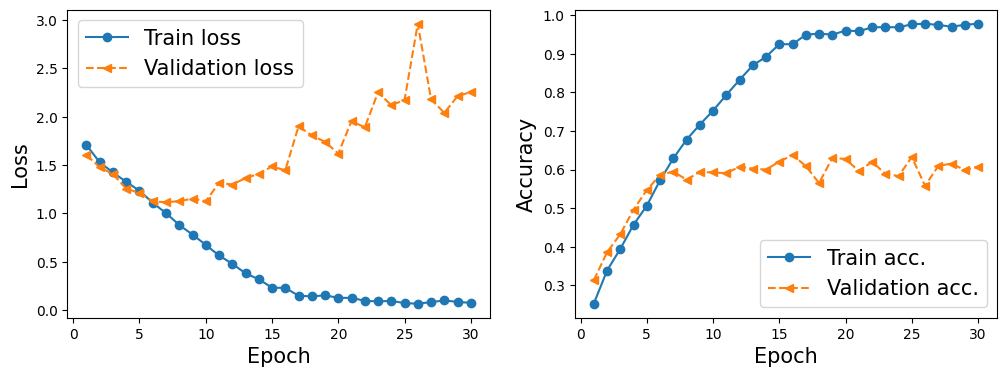

In [96]:
make_picture(hist)

In [97]:
acc_test, _ = evaluate(test_dl)
print(f'Test accuracy: {acc_test:.4f}')

Test accuracy: 0.6237


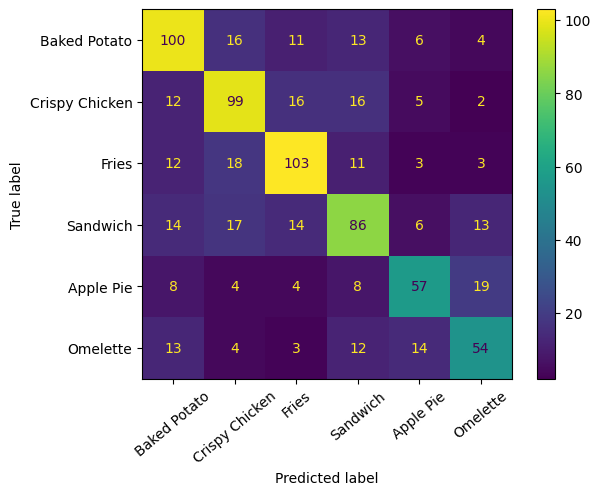

In [98]:
make_confusion_matrix(test_dl)

## Adding BatchNormalization after each convolutional layer

### CNN Model (+ BatchNorm2d)

Po każdej warstwie konwolucyjnej dodajemuy moduł BatchNorm2d(liczba kanałów na wyjściu z konwolucyjnej).

In [99]:
model = nn.Sequential()

#1
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2))
model.add_module('batch1', nn.BatchNorm2d(32))
model.add_module('relu1', nn.ReLU())
#2
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
#3
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('batch2', nn.BatchNorm2d(64))
model.add_module('relu2', nn.ReLU())
#4
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
#5
model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2))
model.add_module('batch3', nn.BatchNorm2d(128))
model.add_module('relu3', nn.ReLU())
#6
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))

In [101]:
x = torch.ones((4, 3, width, hight))
model(x).shape

torch.Size([4, 128, 16, 16])

In [102]:
model.add_module('flatten', nn.Flatten())

x = torch.ones((4, 3, width, hight))
linear_in = model(x).shape[1]
model(x).shape

torch.Size([4, 32768])

In [103]:
model.add_module('fc1', nn.Linear(linear_in, 1024))
model.add_module('relu4', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, len(selected_classes)))

model(x).shape

torch.Size([4, 6])

In [104]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training the model



In [105]:
num_epochs = 150

hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.2921 val_accuracy: 0.3144
Epoch 2 accuracy: 0.3541 val_accuracy: 0.4031
Epoch 3 accuracy: 0.3784 val_accuracy: 0.4125
Epoch 4 accuracy: 0.3834 val_accuracy: 0.3994
Epoch 5 accuracy: 0.3968 val_accuracy: 0.3406
Epoch 6 accuracy: 0.4107 val_accuracy: 0.4375
Epoch 7 accuracy: 0.4298 val_accuracy: 0.4669
Epoch 8 accuracy: 0.4425 val_accuracy: 0.4150
Epoch 9 accuracy: 0.4564 val_accuracy: 0.4688
Epoch 10 accuracy: 0.4782 val_accuracy: 0.5200
Epoch 11 accuracy: 0.4916 val_accuracy: 0.4212
Epoch 12 accuracy: 0.5148 val_accuracy: 0.4969
Epoch 13 accuracy: 0.5227 val_accuracy: 0.5225
Epoch 14 accuracy: 0.5341 val_accuracy: 0.5981
Epoch 15 accuracy: 0.5462 val_accuracy: 0.5575
Epoch 16 accuracy: 0.5618 val_accuracy: 0.5500
Epoch 17 accuracy: 0.5668 val_accuracy: 0.5994
Epoch 18 accuracy: 0.5866 val_accuracy: 0.5644
Epoch 19 accuracy: 0.5884 val_accuracy: 0.5975
Epoch 20 accuracy: 0.6054 val_accuracy: 0.5119
Epoch 21 accuracy: 0.6157 val_accuracy: 0.5119
Epoch 22 accuracy: 0.6

### Plot, accuracy, and confusion matrix

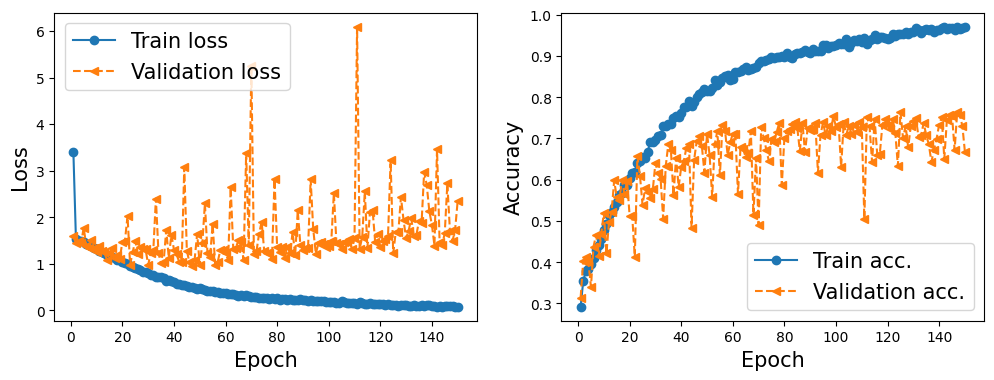

In [106]:
make_picture(hist)

In [107]:
acc_test, _ = evaluate(test_dl)
print(f'Test accuracy: {acc_test:.4f}')

Test accuracy: 0.6812


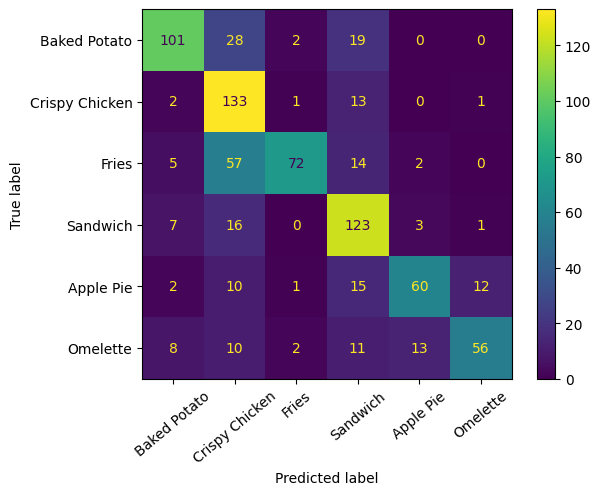

In [108]:
make_confusion_matrix(test_dl)

## Plot, Accuracy, and Confusion Matrix

### Augmentation (resize = 64x64)

In [109]:
from torchvision import transforms

## for training
width, hight = 64, 64
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize([width, hight]),
    transforms.ToTensor(),
])

## for test and validation dataset
transform = transforms.Compose([
    transforms.Resize([width, hight]),
    transforms.ToTensor(),
])

### Preparing DataLoader

In [110]:
image_train_dataset = ImageDataset(trainn['filename'].to_list(), trainn['labels'].to_list(), transform_train)
image_valid_dataset = ImageDataset(valid['filename'].to_list(), valid['labels'].to_list(), transform)
image_test_dataset = ImageDataset(test['filename'].to_list(), test['labels'].to_list(), transform)

torch.manual_seed(1)
batch_size = 32
train_dl = DataLoader(image_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(image_valid_dataset, batch_size, shuffle=False)
test_dl = DataLoader(image_test_dataset, batch_size, shuffle=False)

### Model CNN (Convolutional layers twice as large)

In [118]:
model = nn.Sequential()

#1
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2))
model.add_module('batch1', nn.BatchNorm2d(64))
model.add_module('relu1', nn.ReLU())
#2
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
#3
model.add_module('conv2', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2))
model.add_module('batch2', nn.BatchNorm2d(128))
model.add_module('relu2', nn.ReLU())
#4
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
#5
model.add_module('conv3', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=2))
model.add_module('batch3', nn.BatchNorm2d(256))
model.add_module('relu3', nn.ReLU())
#6
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))

In [119]:
x = torch.ones((4, 3, width, hight))
model(x).shape

torch.Size([4, 256, 8, 8])

In [120]:
model.add_module('flatten', nn.Flatten())

x = torch.ones((4, 3, width, hight))
linear_in = model(x).shape[1]
model(x).shape

torch.Size([4, 16384])

In [121]:
model.add_module('fc1', nn.Linear(linear_in, 1024))
model.add_module('relu4', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, len(selected_classes)))

model(x).shape

torch.Size([4, 6])

In [122]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training the model

In [123]:
num_epochs = 80

hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.2823 val_accuracy: 0.3075
Epoch 2 accuracy: 0.3487 val_accuracy: 0.2763
Epoch 3 accuracy: 0.3745 val_accuracy: 0.3063
Epoch 4 accuracy: 0.4062 val_accuracy: 0.3088
Epoch 5 accuracy: 0.4482 val_accuracy: 0.4256
Epoch 6 accuracy: 0.4652 val_accuracy: 0.4137
Epoch 7 accuracy: 0.4787 val_accuracy: 0.3137
Epoch 8 accuracy: 0.5025 val_accuracy: 0.4850
Epoch 9 accuracy: 0.5066 val_accuracy: 0.2606
Epoch 10 accuracy: 0.5423 val_accuracy: 0.5156
Epoch 11 accuracy: 0.5600 val_accuracy: 0.6150
Epoch 12 accuracy: 0.5796 val_accuracy: 0.4756
Epoch 13 accuracy: 0.5929 val_accuracy: 0.3725
Epoch 14 accuracy: 0.5880 val_accuracy: 0.5619
Epoch 15 accuracy: 0.5984 val_accuracy: 0.6050
Epoch 16 accuracy: 0.6136 val_accuracy: 0.5119
Epoch 17 accuracy: 0.6191 val_accuracy: 0.6181
Epoch 18 accuracy: 0.6425 val_accuracy: 0.6056
Epoch 19 accuracy: 0.6420 val_accuracy: 0.6087
Epoch 20 accuracy: 0.6561 val_accuracy: 0.5831
Epoch 21 accuracy: 0.6659 val_accuracy: 0.5894
Epoch 22 accuracy: 0.6

### Plot, Accuracy, and Confusion Matrix

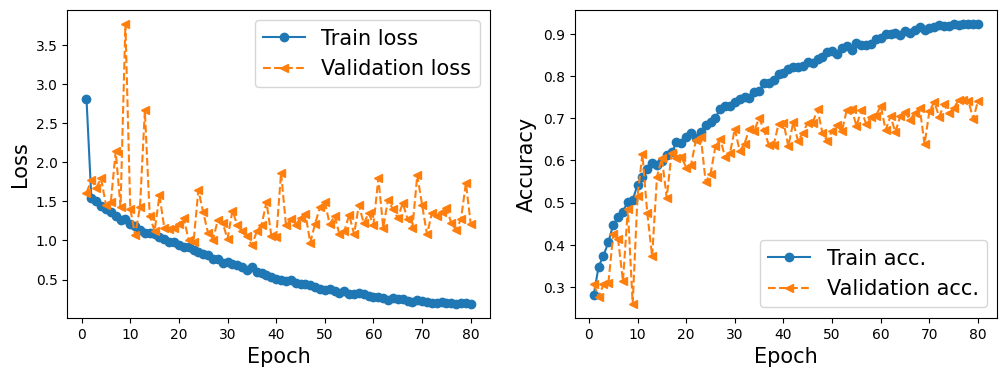

In [124]:
make_picture(hist)

In [125]:
acc_test, _ = evaluate(test_dl)
print(f'Test accuracy: {acc_test:.4f}')

Test accuracy: 0.7362


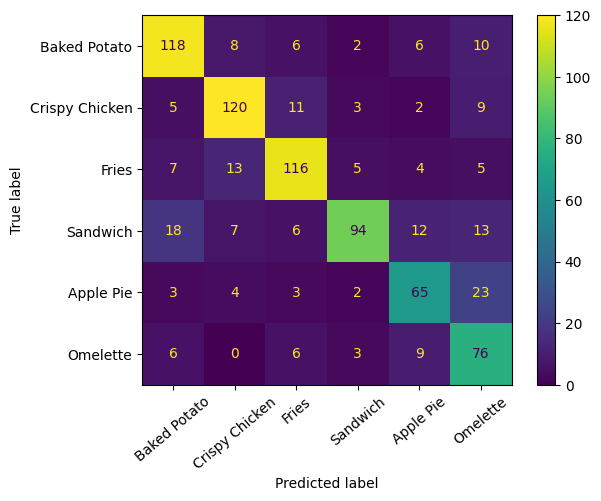

In [126]:
make_confusion_matrix(test_dl)

## Adding a Variable Learning Rate (LR)

### CNN Model (no changes)

In [127]:
model = nn.Sequential()

#1
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2))
model.add_module('batch1', nn.BatchNorm2d(64))
model.add_module('relu1', nn.ReLU())
#2
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
#3
model.add_module('conv2', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2))
model.add_module('batch2', nn.BatchNorm2d(128))
model.add_module('relu2', nn.ReLU())
#4
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
#5
model.add_module('conv3', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=2))
model.add_module('batch3', nn.BatchNorm2d(256))
model.add_module('relu3', nn.ReLU())
#6
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))

In [128]:
x = torch.ones((4, 3, width, hight))
model(x).shape

torch.Size([4, 256, 8, 8])

In [129]:
model.add_module('flatten', nn.Flatten())

x = torch.ones((4, 3, width, hight))
linear_in = model(x).shape[1]
model(x).shape

torch.Size([4, 16384])

In [130]:
model.add_module('fc1', nn.Linear(linear_in, 1024))
model.add_module('relu4', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, len(selected_classes)))

model(x).shape

torch.Size([4, 6])

In [131]:
model = model.to(device)

In [132]:
from torch.optim import lr_scheduler

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Zmienny LR
lmbda = lambda epoch: 0.95
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

In [133]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        scheduler.step()

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

### Training the model

In [134]:
num_epochs = 80

hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.2777 val_accuracy: 0.3400
Epoch 2 accuracy: 0.3691 val_accuracy: 0.3438
Epoch 3 accuracy: 0.4255 val_accuracy: 0.4644
Epoch 4 accuracy: 0.4620 val_accuracy: 0.4931
Epoch 5 accuracy: 0.5098 val_accuracy: 0.4744
Epoch 6 accuracy: 0.5400 val_accuracy: 0.4650
Epoch 7 accuracy: 0.5593 val_accuracy: 0.5250
Epoch 8 accuracy: 0.5788 val_accuracy: 0.4094
Epoch 9 accuracy: 0.6104 val_accuracy: 0.5450
Epoch 10 accuracy: 0.6100 val_accuracy: 0.6156
Epoch 11 accuracy: 0.6305 val_accuracy: 0.6175
Epoch 12 accuracy: 0.6446 val_accuracy: 0.6144
Epoch 13 accuracy: 0.6598 val_accuracy: 0.5706
Epoch 14 accuracy: 0.6639 val_accuracy: 0.6306
Epoch 15 accuracy: 0.6825 val_accuracy: 0.5450
Epoch 16 accuracy: 0.6882 val_accuracy: 0.5462
Epoch 17 accuracy: 0.7080 val_accuracy: 0.5700
Epoch 18 accuracy: 0.7255 val_accuracy: 0.6425
Epoch 19 accuracy: 0.7332 val_accuracy: 0.6700
Epoch 20 accuracy: 0.7416 val_accuracy: 0.6181
Epoch 21 accuracy: 0.7521 val_accuracy: 0.6569
Epoch 22 accuracy: 0.7

### Plot, Accuracy, and Confusion Matrix

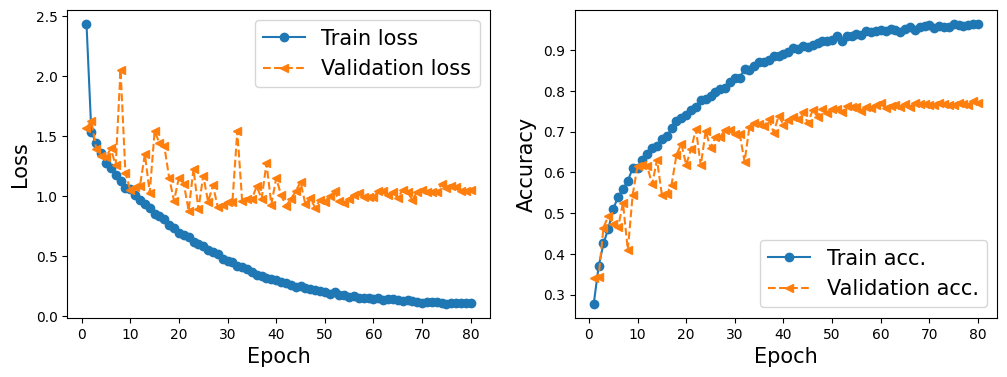

In [135]:
make_picture(hist)

In [136]:
acc_test, _ = evaluate(test_dl)
print(f'Test accuracy: {acc_test:.4f}')

Test accuracy: 0.7563


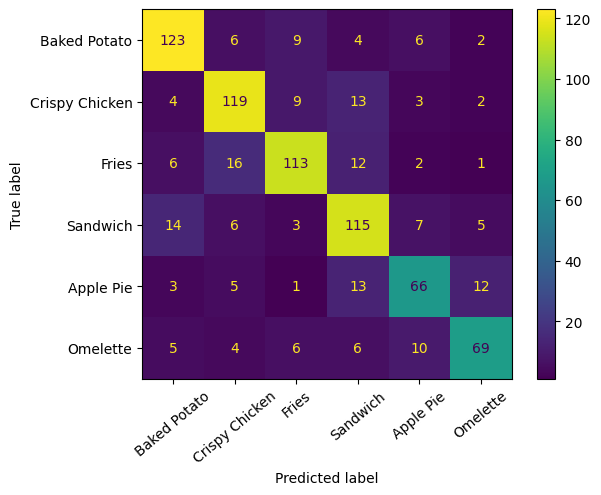

In [137]:
make_confusion_matrix(test_dl)

In [138]:
#Saving the model 5
torch.save(model.state_dict(), "the_best_model.pth")


# Summary

In [139]:
def make_pred_test_labels(test_dl):
  y_test =test['labels'].to_list()
  pred2 = []

  with torch.no_grad():
    for x_batch, y_batch in test_dl:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      pred = model(x_batch)
      a = torch.argmax(pred, dim=1)
      a = a.tolist()
      pred2 += a

  return pred2, y_test

In [140]:
pred_lab, test_lab = make_pred_test_labels(test_dl)
test.reset_index(inplace=True, drop=True)

## Examples of misclassified images

* Upper text in black: actual label
* Lower text in red: prediction

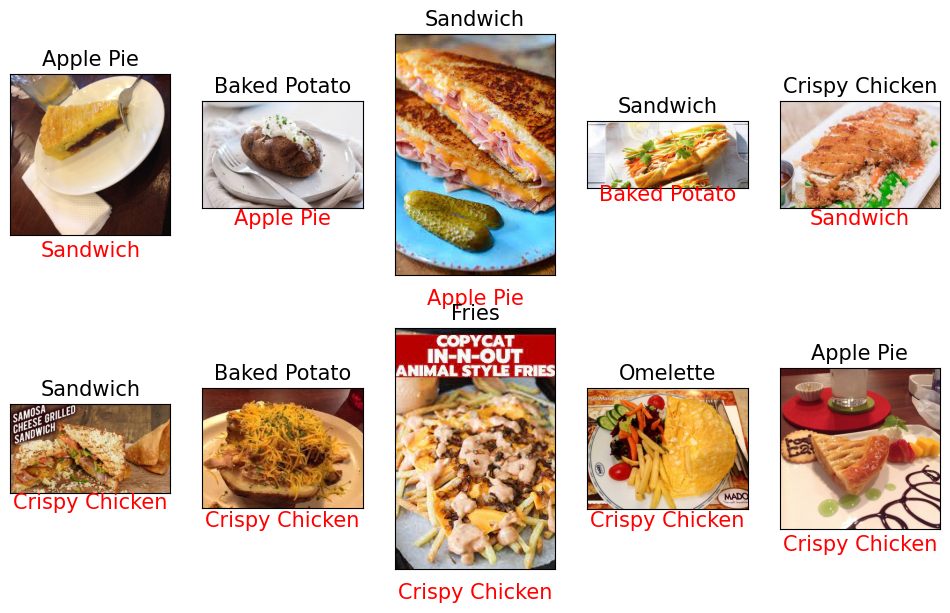

In [141]:
fig = plt.figure(figsize=(12, 7))
j=1

for i in range(len(test_lab)):
    if pred_lab[i]!=test_lab[i]:
        ax = fig.add_subplot(2, 5, j)
        img = Image.open(test['filename'][i])
        ax.set_title(selected_classes[test_lab[i]], size=15)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(img)
        ax.text(0.5, -0.1, selected_classes[pred_lab[i]],
            size=15, color='red',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)
        j+=1
    if j>10:
        break
plt.show()

## Examples of correctly classified images

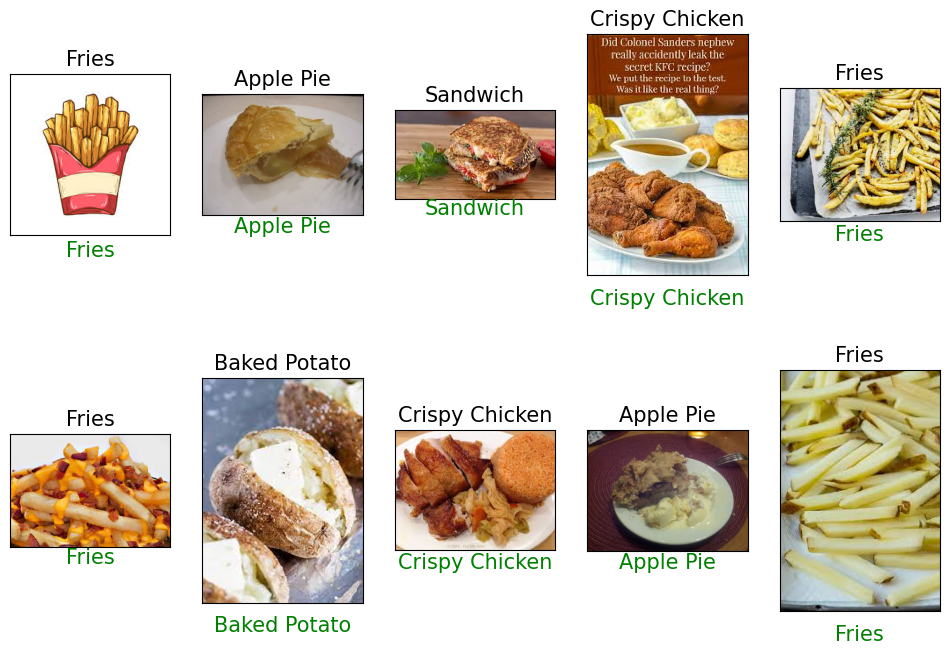

In [142]:
fig = plt.figure(figsize=(12, 8))
j=1

for i in range(len(test_lab)):
    if pred_lab[i]==test_lab[i]:
        ax = fig.add_subplot(2, 5, j)
        img = Image.open(test['filename'][i])
        ax.set_title(selected_classes[test_lab[i]], size=15)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(img)
        ax.text(0.5, -0.1, selected_classes[pred_lab[i]],
            size=15, color='green',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)
        j+=1
    if j>10:
        break
plt.show()